In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import glob
import pickle
from collections import defaultdict, Counter
import warnings
import Bio.PDB
import gctree

In [2]:
out_dir = "output/mutations"

## DMS single AA mutant effects on affinity

In [3]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-128


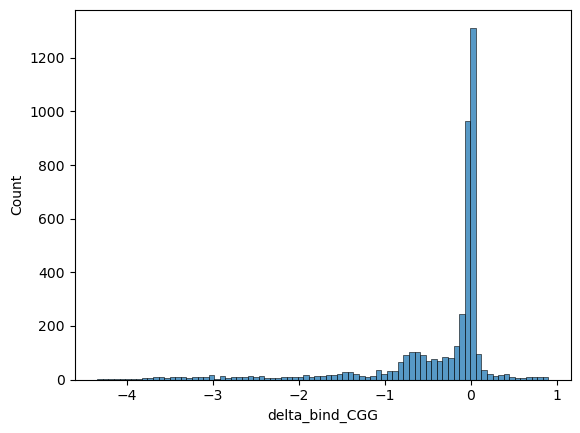

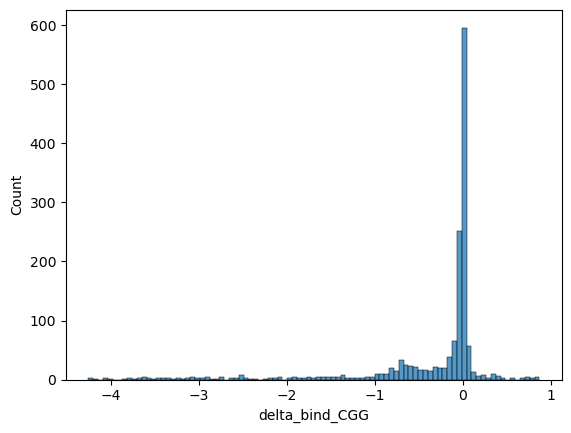

In [4]:
sns.histplot(data=dms_df, x="delta_bind_CGG")
plt.show()

sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG")
plt.show()

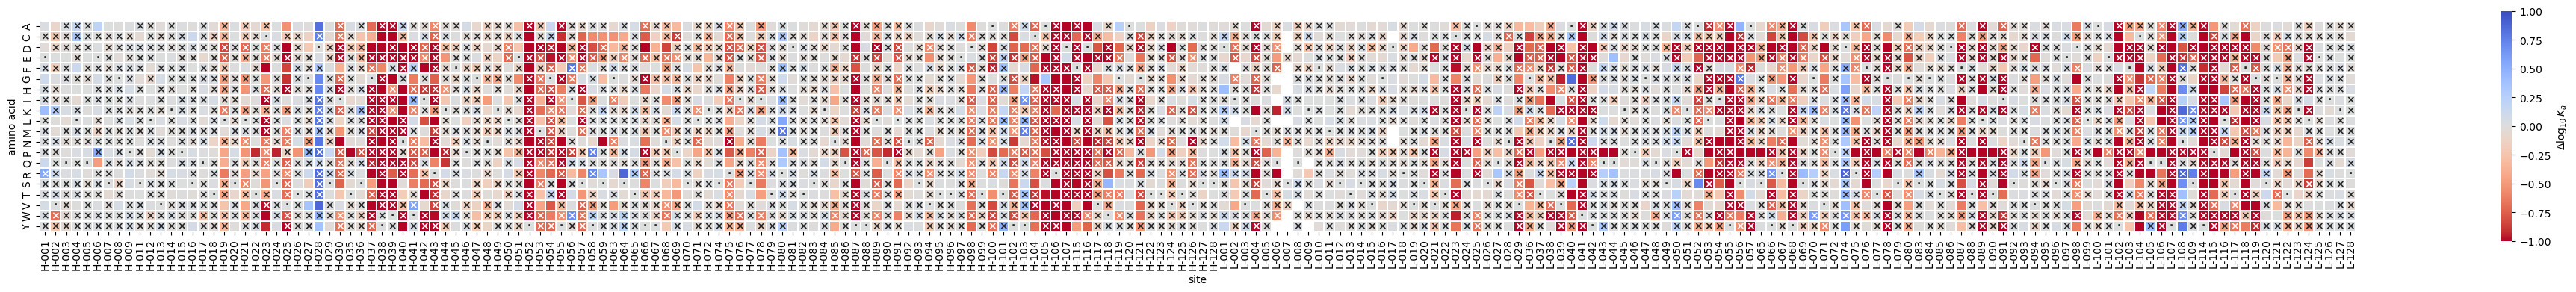

In [5]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind_CGG")

accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00B7"
annot.iloc[~accessible_df.values.astype(bool)] = "\u00D7"

vmax = 1
vmin = -1

plt.figure(figsize=(50, 4))
sns.heatmap(bind_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="coolwarm_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig(f"{out_dir}/heatmap.bind.pdf")
plt.show()

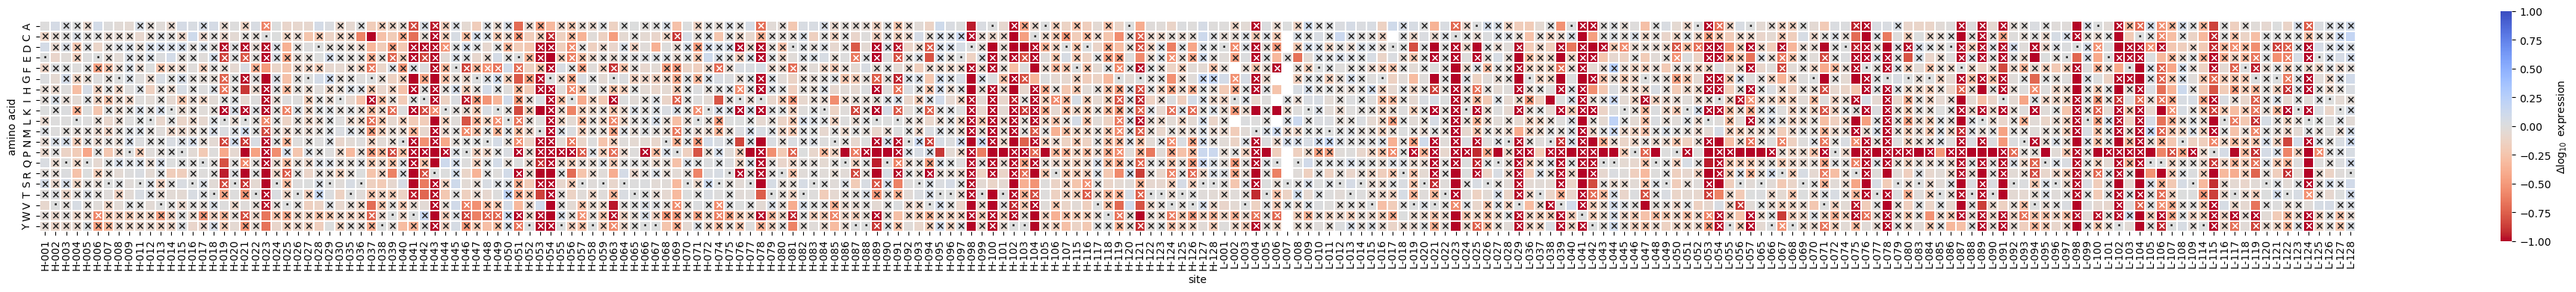

In [6]:
expr_df = dms_df.pivot(index="mutant", columns="site", values="delta_expr")

plt.figure(figsize=(50, 4))
sns.heatmap(expr_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="coolwarm_r", cbar_kws=dict(label=r"$\Delta\log_{10}$ expression"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig(f"{out_dir}/heatmap.expr.pdf")
plt.show()

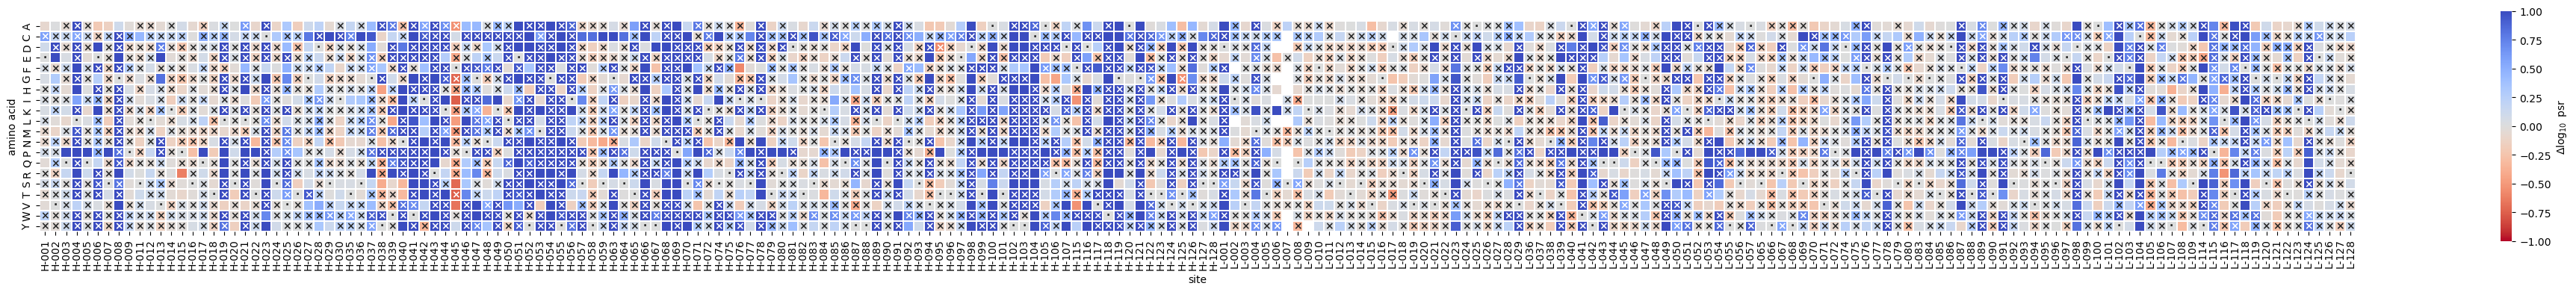

In [7]:
psr_df = dms_df.pivot(index="mutant", columns="site", values="delta_psr")

plt.figure(figsize=(50, 4))
sns.heatmap(psr_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="coolwarm_r", cbar_kws=dict(label=r"$\Delta\log_{10}$ psr"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig(f"{out_dir}/heatmap.psr.pdf")
plt.show()

## Mutations in GC trees

In [8]:
results = "../nextflow/results/latest"

In [9]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
    print(key)
    # if key.startswith("mouse7") or key.startswith("mouse8"):
    #     print(f"skipping 10-week {key}")
    #     continue
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

mouse1_GC1
mouse1_GC2
mouse1_GC3
mouse1_GC4
mouse1_GC5
mouse1_GC6
mouse1_GC7
mouse1_GC11
mouse1_GC12
mouse1_GC13
mouse1_GC14
mouse1_GC15
mouse1_GC16
mouse1_GC17
mouse1_GC18
mouse1_GC19
mouse1_GC20
mouse2_GC21
mouse2_GC22
mouse2_GC23
mouse2_GC24
mouse2_GC25
mouse2_GC26
mouse2_GC28
mouse2_GC29
mouse2_GC30
mouse2_GC31
mouse2_GC32
mouse2_GC34
mouse2_GC38
mouse2_GC39
mouse2_GC40
mouse3_GC41
mouse3_GC42
mouse3_GC43
mouse3_GC44
mouse3_GC45
mouse3_GC46
mouse3_GC55
mouse3_GC56
mouse3_GC57
mouse3_GC58
mouse3_GC59
mouse3_GC64
mouse3_GC65
mouse3_GC66
mouse3_GC72
mouse4_GC47
mouse4_GC48
mouse4_GC50
mouse4_GC63
mouse4_GC67
mouse4_GC68
mouse4_GC69
mouse4_GC70
mouse4_GC71
mouse4_GC73
mouse5_GC78
mouse5_GC79
mouse5_GC80
mouse5_GC81
mouse5_GC82
mouse5_GC83
mouse6_GC74
mouse6_GC75
mouse6_GC76
mouse6_GC77
mouse7_GC90
mouse7_GC91
mouse7_GC92
mouse7_GC93
mouse8_GC84
mouse8_GC85
mouse8_GC86
mouse8_GC87
mouse8_GC88
mouse8_GC89
mouse11_GC111
mouse11_GC113
mouse11_GC114
mouse11_GC115
mouse11_GC117
mouse11_GC118

In [10]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [11]:
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-128


In [12]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Mutation events

In [13]:
hits_df = pd.DataFrame(np.zeros_like(bind_df.values), index=bind_df.index, columns=bind_df.columns)

dms_df["mutation events (20-day)"] = 0
dms_df["mutation events (10-week)"] = 0
dms_df["mutation events (LMP2A)"] = 0
dms_df["mutation events"] = 0

for gc, tree in trees.items():
    mouse_num = int(gc.split("_")[0][5:])
    if mouse_num in range(1, 7):
        suffix = "20-day"
    elif mouse_num in (7, 8):
        suffix = "10-week"
    elif mouse_num in (11, 12):
        suffix = "LMP2A"
    else:
        raise ValueError(f"unknown mouse {mouse_num}")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        for mutation in set(node.mutations) - set(node.up.mutations):
            mutant = mutation[-1]
            if mutant != "*":
                site = dms_df.site[mutation]
                hits_df.loc[mutant, site] += 1
                dms_df.loc[mutation, "mutation events"] += 1
                dms_df.loc[mutation, f"mutation events ({suffix})"] += 1

hits_df

site,H-001,H-002,H-003,H-004,H-005,H-006,H-007,H-008,H-009,H-011,...,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128
mutant,,,,,,,,,,,,,,,,,,,,,
A,4.0,2.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,...,6.0,7.0,0.0,3.0,1.0,1.0,3.0,2.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,14.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,30.0,0.0,0.0,0.0
E,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,6.0,0.0,26.0,0.0,0.0,0.0,30.0,0.0
F,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
G,7.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,11.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
H,0.0,0.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,13.0,0.0
K,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,14.0,0.0,0.0


In [14]:
dms_df.loc["A105(H)G"]

target                       CGG_naive
wildtype                             A
position                            96
position_IMGT                      105
chain                                H
annotation                       CDRH3
mutant                               G
codon                              GCA
single_nt                         True
bind_CGG                      10.78819
delta_bind_CGG                   0.331
n_bc_bind_CGG                     15.0
n_libs_bind_CGG                    2.0
bind_TuGG                      6.25772
delta_bind_TuGG               -0.08157
n_bc_bind_TuGG                    17.0
n_libs_bind_TuGG                   2.0
expr                          10.44506
delta_expr                    -0.00561
n_bc_expr                         18.0
n_libs_expr                        2.0
psr                            6.58706
delta_psr                     -0.27353
n_bc_psr                          15.0
n_libs_psr                         2.0
WT                       

In [15]:
hits_df.max().max()

318.0

## Comparing mutation incidence across mouse types

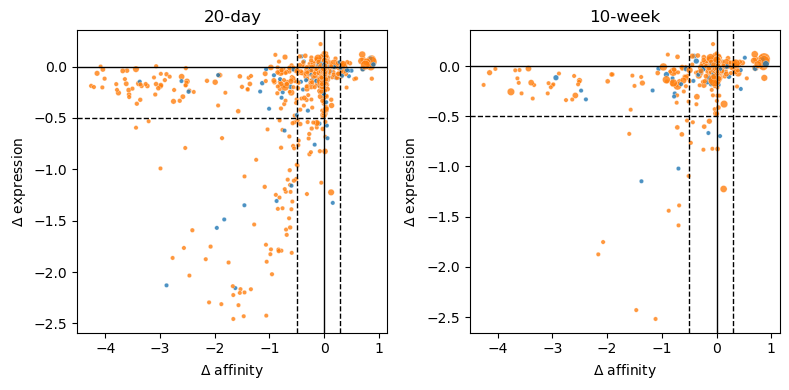

In [16]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
sns.scatterplot(data=dms_df.query("`mutation events (20-day)` > 0"), y="delta_expr", x="delta_bind_CGG",
                hue="single_nt", size="mutation events (20-day)",
                sizes=(10, 100),
                legend=False,
                alpha=0.8,
#             cmap="viridis",
#             vmin=0,
            # vmax=15
           )
plt.axvline(0, ls="-", c="k", lw=1)
plt.axvline(-0.5, ls="--", c="k", lw=1)
plt.axvline(0.3, ls="--", c="k", lw=1)
plt.axhline(0, ls="-", c="k", lw=1)
plt.axhline(-0.5, ls="--", c="k", lw=1)
plt.title("20-day")
plt.ylabel(r"$\Delta$ expression")
plt.xlabel(r"$\Delta$ affinity")

plt.subplot(122)
sns.scatterplot(data=dms_df.query("`mutation events (10-week)` > 0"), y="delta_expr", x="delta_bind_CGG",
                hue="single_nt", size="mutation events (10-week)",
                sizes=(10, 100),
                legend=False,
                alpha=0.8,
#             cmap="viridis",
#             vmin=0,
            # vmax=15
           )
plt.axvline(0, ls="-", c="k", lw=1)
plt.axvline(-0.5, ls="--", c="k", lw=1)
plt.axvline(0.3, ls="--", c="k", lw=1)
plt.axhline(0, ls="-", c="k", lw=1)
plt.axhline(-0.5, ls="--", c="k", lw=1)
plt.title("10-week")
plt.ylabel(r"$\Delta$ expression")
plt.xlabel(r"$\Delta$ affinity")

plt.savefig(f"{out_dir}/bind-expr-mice.pdf")
plt.tight_layout()
plt.show()

accessible mutations observed in 20-day mice: 894
accessible mutations not observed in 20-day mice: 611
inaccessible mutations observed in 20-day mice: 135
inaccessible mutations not observed in 20-day mice: 2760
accessible mutations observed in 10-week mice: 487
accessible mutations not observed in 10-week mice: 1018
inaccessible mutations observed in 10-week mice: 70
inaccessible mutations not observed in 10-week mice: 2825


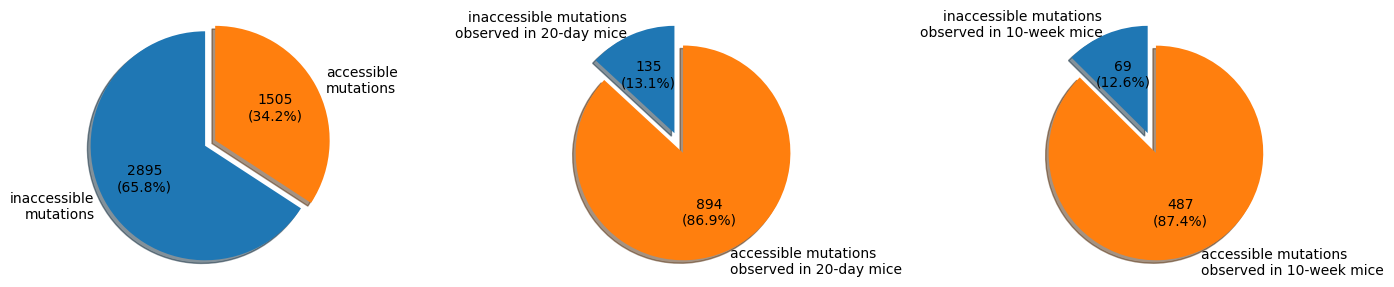

In [17]:
print(f"accessible mutations observed in 20-day mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])}")
print(f"accessible mutations not observed in 20-day mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] == 0)])}")
print(f"inaccessible mutations observed in 20-day mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])}")
print(f"inaccessible mutations not observed in 20-day mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] == 0)])}")

print(f"accessible mutations observed in 10-week mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])}")
print(f"accessible mutations not observed in 10-week mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] == 0)])}")
print(f"inaccessible mutations observed in 10-week mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])}")
print(f"inaccessible mutations not observed in 10-week mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] == 0)])}")

def func(pct, data):
    absolute = int(pct / 100 * np.sum(data))
    return f"{absolute:d}\n({pct:.1f}%)"

plt.figure(figsize=(14, 3))

plt.subplot(131)
data = [len(dms_df) - sum(dms_df.single_nt), sum(dms_df.single_nt)]
plt.pie(data,
        labels=("inaccessible\nmutations", "accessible\nmutations"),
        explode=(0, 0.1), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.subplot(132)
data = [len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)]), len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])]
plt.pie(data,
        labels=("inaccessible mutations\nobserved in 20-day mice", "accessible mutations\nobserved in 20-day mice"),
        explode=(0, 0.2), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.subplot(133)
data = [len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)]), len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])]
plt.pie(data,
        labels=("inaccessible mutations\nobserved in 10-week mice", "accessible mutations\nobserved in 10-week mice"),
        explode=(0, 0.2), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.tight_layout()
plt.savefig(f"{out_dir}/piechart.pdf")
plt.show()

# sns.boxplot(data=dms_df, x="single_nt", y="mutation events (20-day)")
# plt.show()

# sns.stripplot(data=dms_df, x="single_nt", y="mutation events (10-week)")
# plt.show()

In [18]:
dms_df[["single_nt", "mutation events (20-day)"]]

,single_nt,mutation events (20-day)
mutation,,
E1(H)A,True,4
E1(H)C,False,0
E1(H)D,True,7
E1(H)E,True,0
E1(H)F,False,0
...,...,...
R128(L)S,True,0
R128(L)T,False,0
R128(L)V,False,0


/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_46686/958861044.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(data=hits_df, ci=None, estimator=sum)


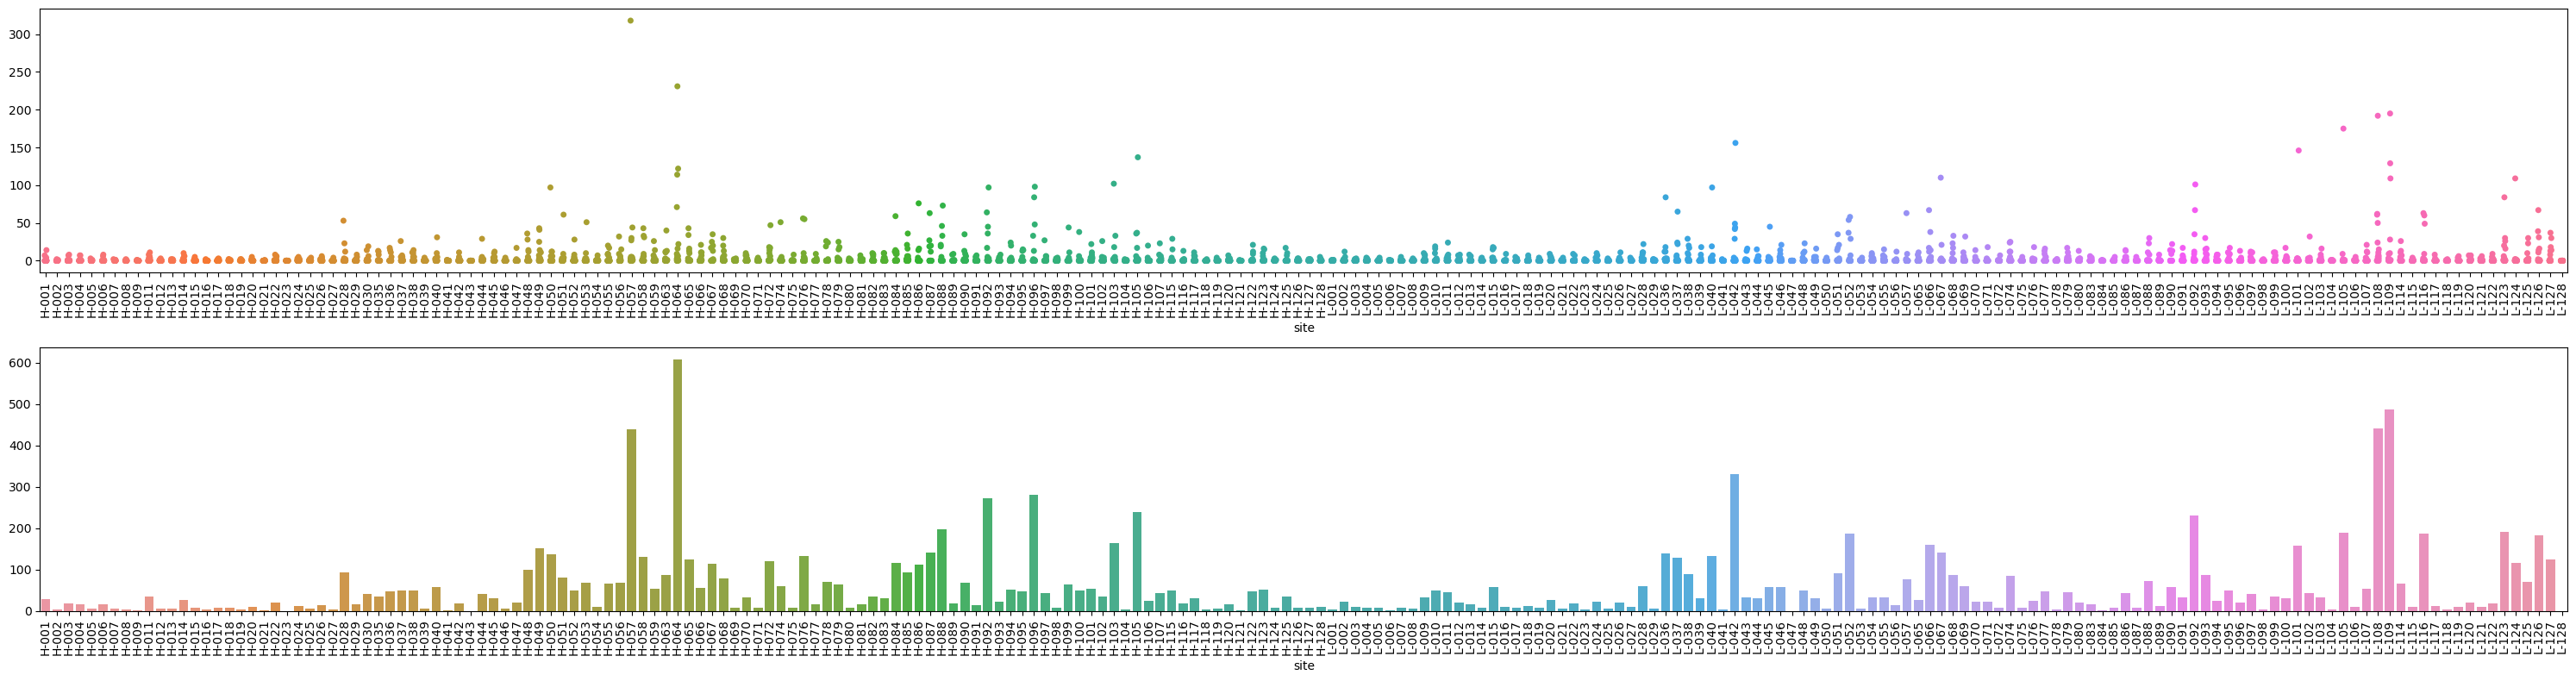

In [19]:
plt.figure(figsize=(30, 8))

plt.subplot(211)
g = sns.stripplot(data=hits_df)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.subplot(212, sharex=g)
g = sns.barplot(data=hits_df, ci=None, estimator=sum)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.tight_layout()
plt.show()

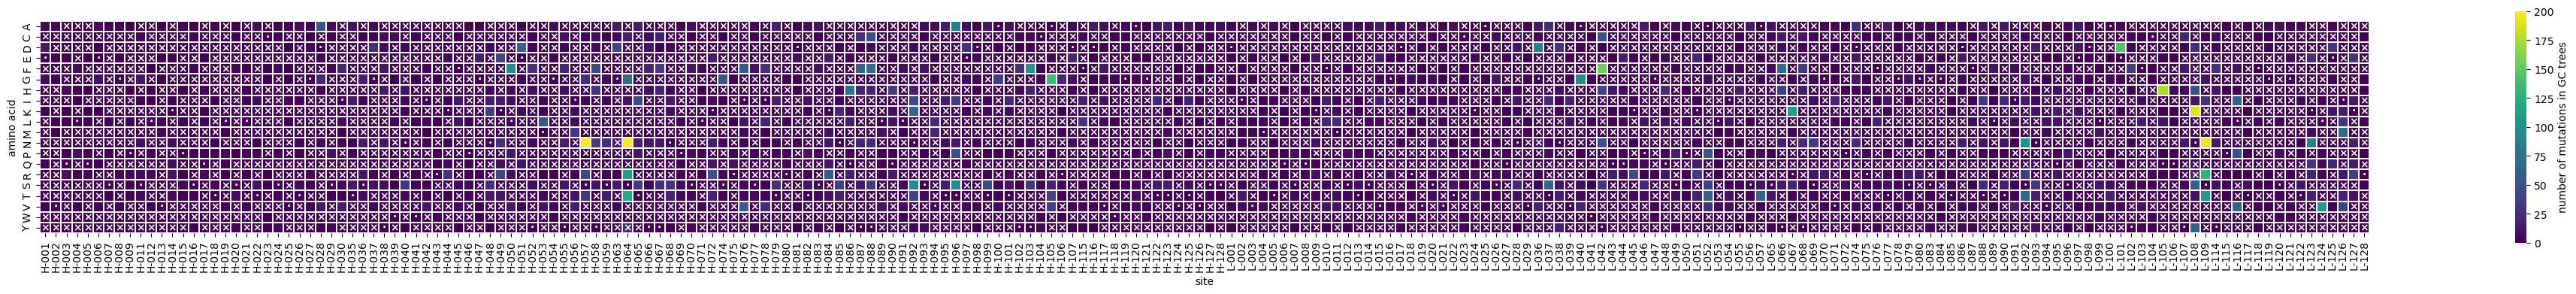

In [20]:
plt.figure(figsize=(50, 4))
sns.heatmap(hits_df, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="viridis",
#             vmin=100,
            vmax=200,
            cbar_kws=dict(label="number of mutations in GC trees"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

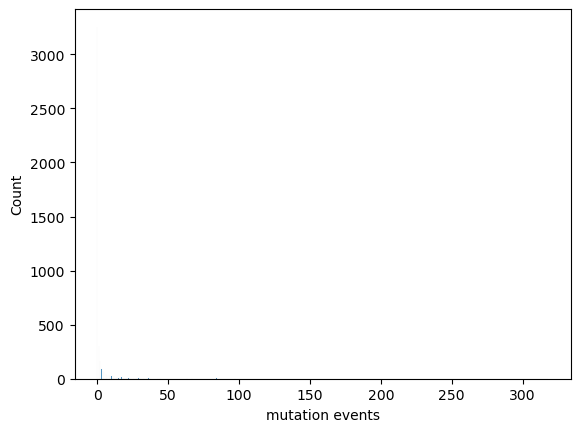

mutation
S57(H)N     318
S64(H)N     231
S109(L)N    195
N108(L)K    192
Q105(L)H    175
Y42(L)F     156
E101(L)D    146
A105(H)G    137
S109(L)R    129
S64(H)T     122
S64(H)R     114
R67(L)K     110
L124(L)V    109
S109(L)T    109
Y103(H)F    102
S92(L)N     101
T96(H)S      98
N92(H)S      97
L50(H)F      97
A40(L)G      97
Name: mutation events, dtype: int64

In [21]:
sns.histplot(data=dms_df, x="mutation events")
plt.show()

dms_df["mutation events"].sort_values(ascending=False)[:20]

## Add mutability to `dms_df`

In [22]:
from Bio.codonalign.codonseq import CodonSeq

mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence
igk_idx = 336

padded_igh = "NN" + naive[:igk_idx] + "NN"
padded_igk = "NN" + naive[igk_idx:] + "NN"
# mutabilities of each nucleotide
contexts = [padded_igh[(i - 2) : (i + 3)]
                for i in range(2, len(padded_igh) - 2)
               ] + [padded_igk[(i - 2) : (i + 3)]
                    for i in range(2, len(padded_igk) - 2)
                   ]

# mutation rates at each site in naive
mutation_rates_nt = pd.concat((mutability[context] * substitution.loc[context] for context in contexts), axis=1).T.reset_index()

# now we want the above at the codon level
codons = CodonSeq(naive)

assert len(contexts) == len(naive) == len(codons)

dms_df["mutation rate"] = 0

for codon_idx in range(codons.get_codon_num()):
    codon = CodonSeq(codons.get_codon(codon_idx))
    aa = codon.translate()
    for codon_pos in range(3):
        idx = 3 * codon_idx + codon_pos
        if idx < igk_idx:
            chain = "H"
            imgt_idx = igh_pos_map[idx // 3]
        else:
            chain = "L"
            imgt_idx = igk_pos_map[(idx - igk_idx) // 3]
        assert naive[idx] == codon[codon_pos]
        for alt_nt in "ACGT":
            if alt_nt != naive[idx]:
                mutated_codon = list(codon)
                mutated_codon[codon_pos] = alt_nt
                mutated_codon = CodonSeq("".join(mutated_codon))
                mutated_aa = mutated_codon.translate()
                if mutated_aa != "*" and mutated_aa != aa:
                    mutation = f"{aa}{imgt_idx}({chain}){mutated_aa}"
                    dms_df.loc[mutation, "mutation rate"] += mutation_rates_nt.loc[idx, alt_nt]
dms_df

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/Bio/codonalign/__init__.py:23: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(


,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,delta_psr,n_bc_psr,n_libs_psr,WT,site,mutation events (20-day),mutation events (10-week),mutation events (LMP2A),mutation events,mutation rate
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,-0.07452,17.0,2.0,False,H-001,4,0,0,4,0.000123
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,0.58174,17.0,2.0,False,H-001,0,0,0,0,0.000000
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,0.09880,13.0,2.0,False,H-001,7,5,2,14,0.000103
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,0.00000,18910.0,2.0,True,H-001,0,0,0,0,0.000000
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,0.05313,21.0,2.0,False,H-001,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,0.07866,33.0,2.0,False,L-128,0,0,0,0,0.000000
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,0.02896,34.0,2.0,False,L-128,0,0,0,0,0.000000
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,-0.07899,24.0,2.0,False,L-128,0,0,0,0,0.000000


In [23]:
dms_df.loc[(dms_df["mutation events"]>100)].sort_values("mutation events")[["delta_bind_CGG", "wildtype", "mutant", "mutation events", "mutation rate"]]

,delta_bind_CGG,wildtype,mutant,mutation events,mutation rate
mutation,,,,,
S92(L)N,-0.03744,S,N,101,0.002640
Y103(H)F,0.04243,Y,F,102,0.000475
S109(L)T,-0.01932,S,T,109,0.001364
L124(L)V,0.00500,L,V,109,0.001673
R67(L)K,0.00603,R,K,110,0.000500
S64(H)R,0.86927,S,R,114,0.000931
S64(H)T,-0.03998,S,T,122,0.001997
S109(L)R,0.75471,S,R,129,0.001923
A105(H)G,0.33100,A,G,137,0.000357


In [24]:
dms_df.loc["N108(L)E"]

target                       CGG_naive
wildtype                             N
position                           219
position_IMGT                      108
chain                                L
annotation                       CDRL3
mutant                               E
codon                              AAC
single_nt                        False
bind_CGG                       9.54056
delta_bind_CGG                -0.91663
n_bc_bind_CGG                     37.0
n_libs_bind_CGG                    2.0
bind_TuGG                      6.11732
delta_bind_TuGG               -0.22197
n_bc_bind_TuGG                    40.0
n_libs_bind_TuGG                   2.0
expr                          10.36579
delta_expr                    -0.08488
n_bc_expr                         41.0
n_libs_expr                        2.0
psr                            6.60032
delta_psr                     -0.26028
n_bc_psr                          40.0
n_libs_psr                         2.0
WT                       

In [25]:
pos_df.loc[90:100]

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
90,T,H,99,ACA,FWRH3
91,A,H,100,GCC,FWRH3
92,T,H,101,ACA,FWRH3
93,Y,H,102,TAT,FWRH3
94,Y,H,103,TAC,FWRH3
95,C,H,104,TGT,FWRH3
96,A,H,105,GCA,CDRH3
97,R,H,106,AGG,CDRH3
98,D,H,107,GAC,CDRH3


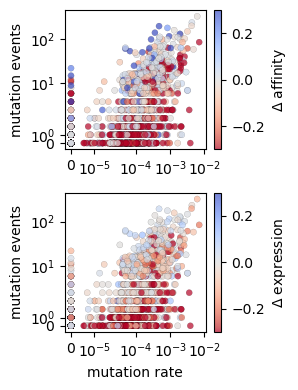

In [26]:
plt.figure(figsize=(3, 4))

ax = plt.subplot(211)
plt.scatter(dms_df["mutation rate"], dms_df["mutation events"], c=dms_df["delta_bind_CGG"], s=20, alpha=0.7,
            cmap="coolwarm_r", vmin=-0.3, vmax=0.3,
            clip_on=False, edgecolors="k", linewidths=0.1)
# plt.xlabel("mutation rate")
plt.ylabel("mutation events")
linthresh_x = 3 * dms_df.loc[dms_df["mutation rate"] > 0, "mutation rate"].min()
linthresh_y = 6
plt.xscale("symlog", linthresh=linthresh_x)
plt.yscale("symlog", linthresh=linthresh_y)
plt.colorbar(label=r"$\Delta$ affinity")

plt.subplot(212, sharex=ax)
plt.scatter(dms_df["mutation rate"], dms_df["mutation events"], c=dms_df["delta_expr"], s=20, alpha=0.7,
            cmap="coolwarm_r", vmin=-0.3, vmax=0.3,
            clip_on=False, edgecolors="k", linewidths=0.1)
plt.xlabel("mutation rate")
plt.ylabel("mutation events")
plt.xscale("symlog", linthresh=linthresh_x)
plt.yscale("symlog", linthresh=linthresh_y)
plt.colorbar(label=r"$\Delta$ expression")

plt.tight_layout()
plt.savefig(f"{out_dir}/eventsVsrate.pdf")
plt.show()

Event / rate Vs affinity (getting at selection sensitivity)

In [91]:
gain_thresh = 0.3
loss_thresh = -1
dms_df.loc[~dms_df.delta_bind_CGG.isna(), "affinity change stratum"] = "affinity neutral"
dms_df.loc[dms_df.delta_bind_CGG > gain_thresh, "affinity change stratum"] = "affinity gain"
dms_df.loc[dms_df.delta_bind_CGG < loss_thresh, "affinity change stratum"] = "affinity loss"

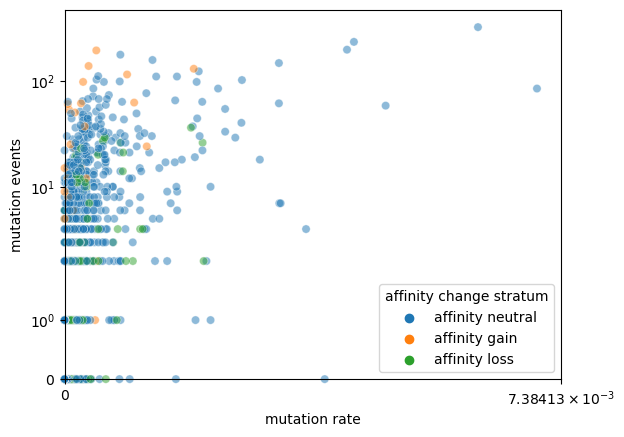

In [94]:
sns.scatterplot(data=dms_df, hue="affinity change stratum", y="mutation events", x="mutation rate", alpha=0.5, clip_on=False)
plt.xscale("symlog")
plt.yscale("symlog")
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

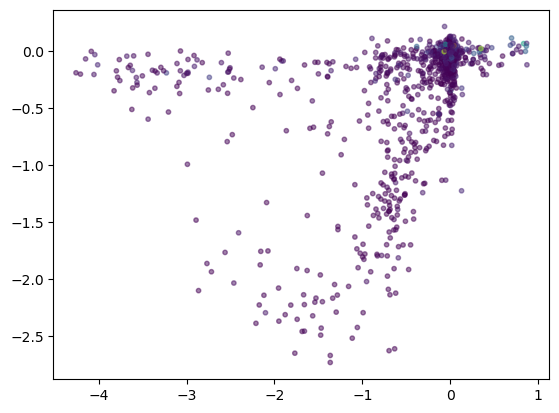

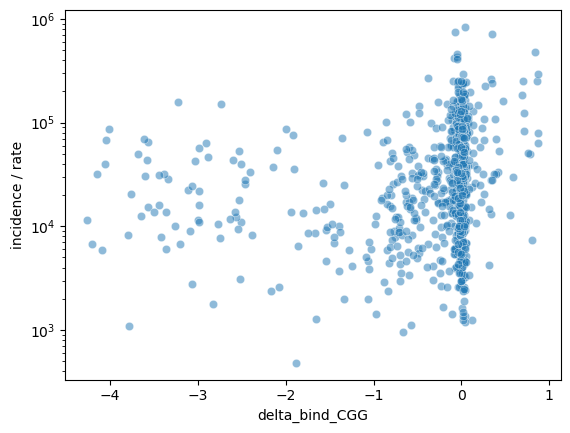

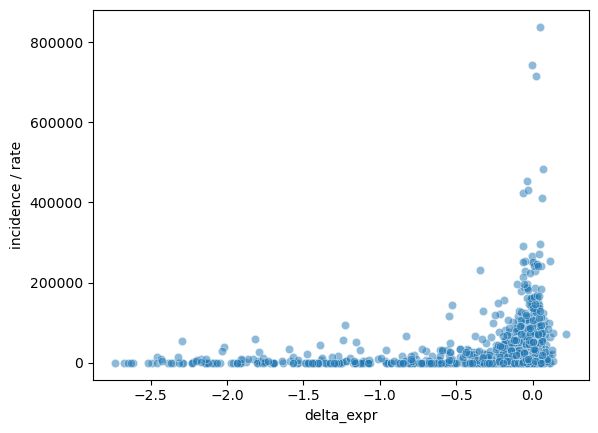

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/numpy/lib/function_base.py:4530: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)


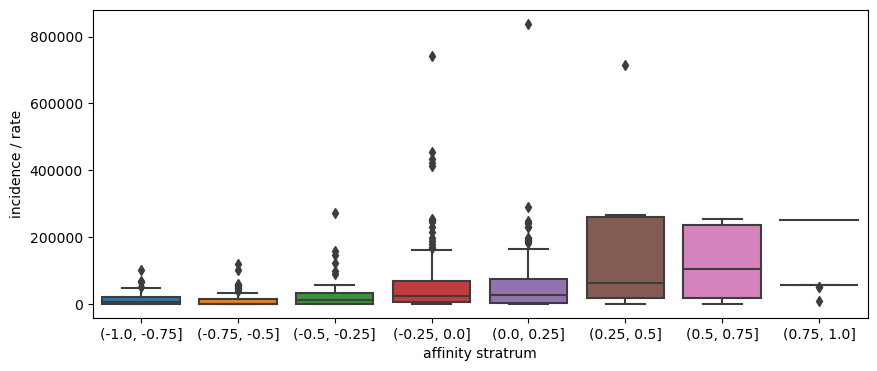

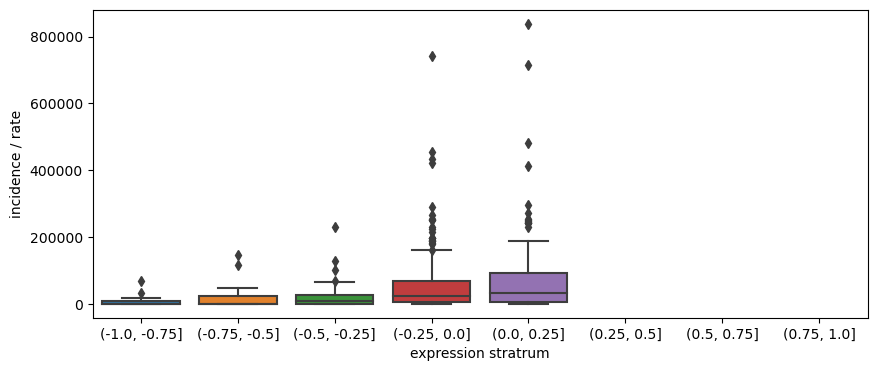

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


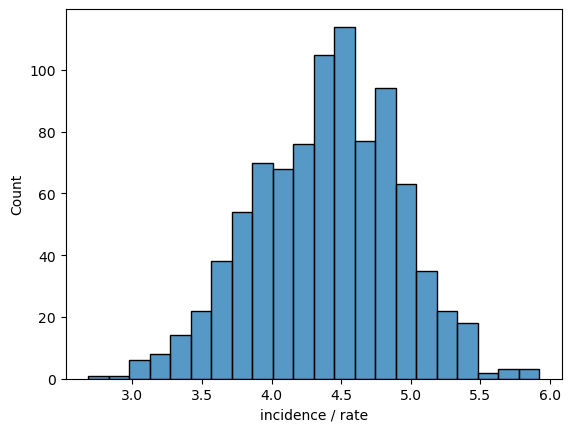

In [109]:
affinity_incidence_rate_df = dms_df[["delta_bind_CGG", "delta_expr", "mutation events (20-day)", "mutation rate"]].copy()
affinity_incidence_rate_df["incidence / rate"] = affinity_incidence_rate_df["mutation events (20-day)"] / affinity_incidence_rate_df["mutation rate"]

bins = np.linspace(-1, 1, 9)
affinity_incidence_rate_df["affinity stratrum"] = pd.cut(affinity_incidence_rate_df["delta_bind_CGG"], bins=bins)
affinity_incidence_rate_df["expression stratrum"] = pd.cut(affinity_incidence_rate_df["delta_expr"], bins=bins)

plt.scatter(affinity_incidence_rate_df.delta_bind_CGG, affinity_incidence_rate_df.delta_expr, c=affinity_incidence_rate_df["incidence / rate"], alpha=0.5, s=10)
plt.show()

sns.scatterplot(data=affinity_incidence_rate_df, x="delta_bind_CGG", y="incidence / rate", alpha=0.5)
plt.yscale("log")
plt.show()
sns.scatterplot(data=affinity_incidence_rate_df, x="delta_expr", y="incidence / rate", alpha=0.5)
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="affinity stratrum", y="incidence / rate")
plt.show()
plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="expression stratrum", y="incidence / rate")
plt.show()

sns.histplot(x=np.log10(affinity_incidence_rate_df["incidence / rate"]))
plt.show()

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/replay/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/miniconda3/envs/replay/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/miniconda3/envs/replay/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/miniconda3/envs/replay/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/miniconda3/envs/replay/lib/python3.9/site-packages/numpy/core/_met

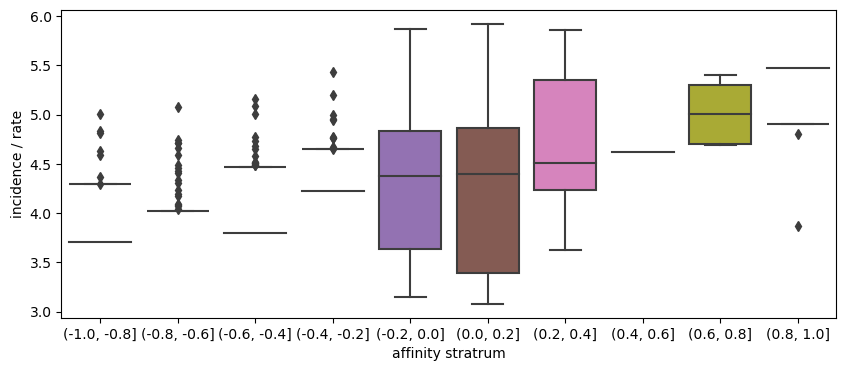

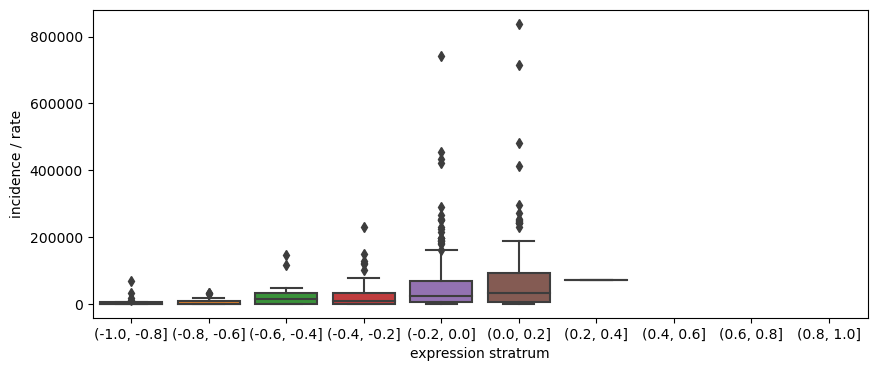

In [108]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=affinity_incidence_rate_df["affinity stratrum"], y=np.log10(affinity_incidence_rate_df["incidence / rate"]))
plt.show()
plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="expression stratrum", y="incidence / rate")
plt.show()

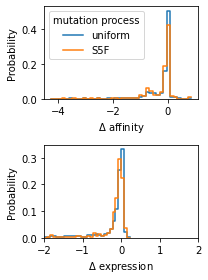

In [ ]:
plt.figure(figsize=(3, 4))

ax = plt.subplot(211)
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", bins=40, stat="probability", element="step", fill=False, label="uniform")
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", bins=40, weights=dms_df.loc[dms_df.single_nt, "mutation rate"], stat="probability", element="step", fill=False, label="S5F")
# plt.xlim(-2, 2)
plt.xlabel(r"$\Delta$ affinity")
# plt.yscale("log")
plt.legend(title="mutation process", fontsize=10)

plt.subplot(212)
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr", bins=40, stat="probability", element="step", fill=False, label="uniform")
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr", bins=40, weights=dms_df.loc[dms_df.single_nt, "mutation rate"], stat="probability", element="step", fill=False, label="S5F")
plt.xlim(-2, 2)
plt.xlabel(r"$\Delta$ expression")
# plt.yscale("log")


# sns.jointplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", y="delta_expr")


plt.tight_layout()
plt.savefig(f"{out_dir}/mutation-bias.pdf")
plt.show()

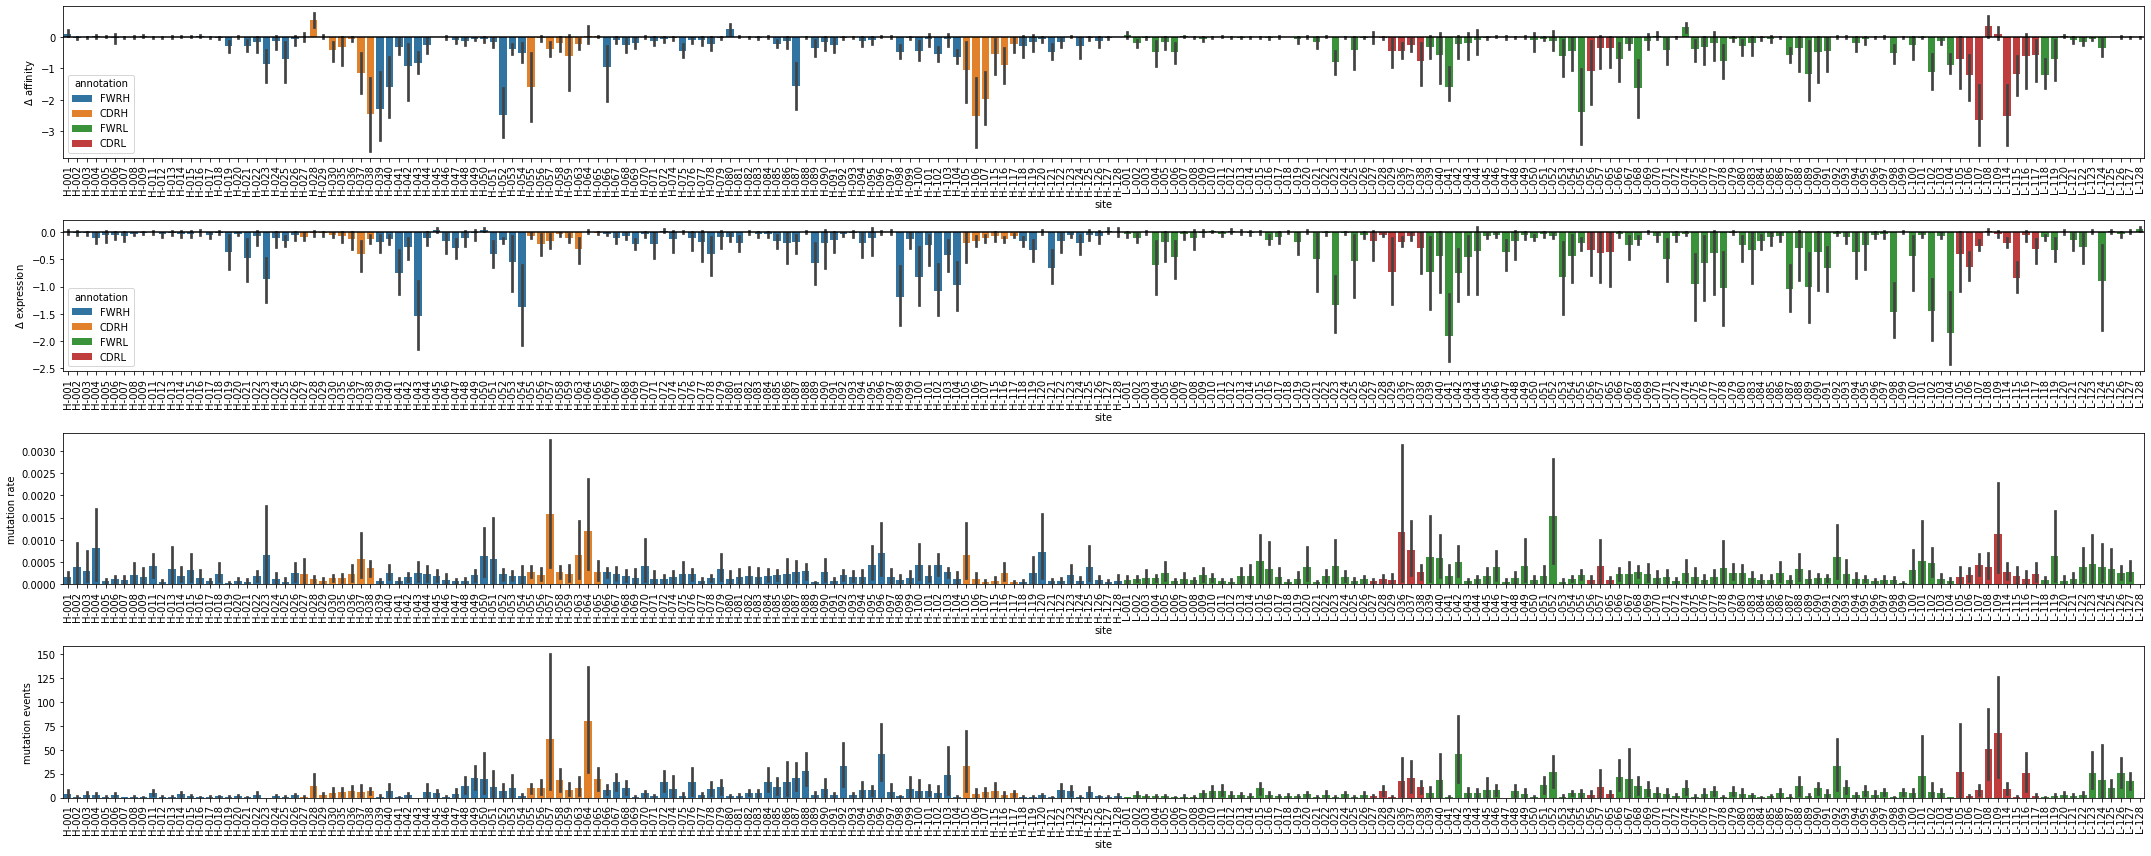

In [ ]:
plt.figure(figsize=(30, 12))
plt.subplot(411)
sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="delta_bind_CGG",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.axhline(0, c="k")
plt.ylabel(r"$\Delta$ affinity")
plt.xticks(rotation=90)

plt.subplot(412)
sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="delta_expr",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.axhline(0, c="k")
plt.ylabel(r"$\Delta$ expression")
plt.xticks(rotation=90)

plt.subplot(413)
g = sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="mutation rate",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.xticks(rotation=90)
g.legend_.remove()

plt.subplot(414)
g = sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="mutation events",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
g.legend_.remove()
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(f"{out_dir}/regions.pdf")
plt.show()

## Binding Vs Expression Vs structure

In [ ]:
# copypasta from polyclonal
def extract_atom_locations(
    input_pdbfile,
    target_chains,
    target_atom="CA",
):
    # read PDB, catch warnings about discontinuous chains
    with warnings.catch_warnings():
        warnings.simplefilter(
            "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
        )
        pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)

    # get the chains out of the PDB
    chains = list(pdb.get_chains())
    chain_ids = [chain.id for chain in chains]

    # make sure the target chains are in the PDB
    for chain in target_chains:
        if chain not in chain_ids:
            raise ValueError(f"{chain} not in {input_pdbfile}")

    # make a list of chains to extract atom locations from
    chains_to_use = []
    for i, chain in enumerate(chain_ids):
        if chain in target_chains:
            chains_to_use.append(chains[i])

    # extract atom locations from target chains
    chain_list = []
    residue_list = []
    x_list = []
    y_list = []
    z_list = []
    for chain in chains_to_use:
        for residue in chain.get_residues():
            residue_number = residue.get_id()[1]
            atoms = residue.get_atoms()
            for atom in atoms:
                if atom.get_id() == target_atom:
                    x, y, z = atom.get_coord()
                    x_list.append(x)
                    y_list.append(y)
                    z_list.append(z)
                    residue_list.append(residue_number)
                    chain_list.append(chain.id)

    # write output
    output = pd.DataFrame(
        {
            "chain": chain_list,
            "site": residue_list,
            "x": x_list,
            "y": y_list,
            "z": z_list,
        }
    )

    return output.reset_index(drop=True)

In [ ]:
# def residue_depth(
#     input_pdbfile,
#     target_chain,
# ):
#     parser = Bio.PDB.PDBParser()
#     # read PDB, catch warnings about discontinuous chains
#     with warnings.catch_warnings():
#         warnings.simplefilter(
#             "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
#         )
#         pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)
#     model = pdb[0]
#     print(list(pdb.get_chains()))
#     rd = Bio.PDB.ResidueDepth(model)
# #     print(rd)
    
# residue_depth("combined_ch2_eh2-coot_IMGT.pdb", "H")

In [ ]:
# !curl https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/dms-view/dms-view/combined_ch2_eh2-coot_IMGT.pdb -o combined_ch2_eh2-coot_IMGT.pdb

In [ ]:
coords_H = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "H").set_index("site").drop("chain", axis=1)
coords_L = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "L").set_index("site").drop("chain", axis=1)
coords_A = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "A").set_index("site").drop("chain", axis=1)
coords_B = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "B").set_index("site").drop("chain", axis=1)
coords_C = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "C").set_index("site").drop("chain", axis=1)
coords_D = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "D").set_index("site").drop("chain", axis=1)

Add distance info to dms_df

In [ ]:
coords_L

,x,y,z
site,,,
1,137.317993,157.432999,169.117004
2,135.832993,154.018005,169.938995
3,134.294006,151.919998,172.697006
4,135.925995,148.505005,172.539001
5,134.113007,146.154007,174.936996
...,...,...,...
119,139.772995,135.639999,181.841003
120,140.578003,131.979996,180.955002
121,139.048996,129.811996,183.735001


In [ ]:
for coords_Ab, chain in zip((coords_H, coords_L), "HL"):
    for i in coords_Ab.index:
        min_dist = np.inf
        for coords_Ag in (coords_A, coords_B, coords_C, coords_D):
            chain_min = np.linalg.norm(coords_Ab.loc[i] - coords_Ag, axis=1).min()
            if chain_min < min_dist:
                min_dist = chain_min
        dms_df.loc[(dms_df.chain == chain) & (dms_df.position_IMGT == i), "distance to antigen"] = min_dist

dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,n_bc_psr,n_libs_psr,WT,site,mutation events,mutation events (20-day),mutation events (10-week),mutation events (LMP2A),mutation rate,distance to antigen
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,17.0,2.0,False,H-001,4,4,0,0,0.000123,9.796122
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,17.0,2.0,False,H-001,0,0,0,0,0.000000,9.796122
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,13.0,2.0,False,H-001,14,7,5,2,0.000103,9.796122
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,18910.0,2.0,True,H-001,0,0,0,0,0.000000,9.796122
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,21.0,2.0,False,H-001,0,0,0,0,0.000000,9.796122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,33.0,2.0,False,L-128,0,0,0,0,0.000000,NaN
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,34.0,2.0,False,L-128,0,0,0,0,0.000000,NaN
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,24.0,2.0,False,L-128,0,0,0,0,0.000000,NaN


In [ ]:
dms_df.to_csv(f"{out_dir}/data.csv")

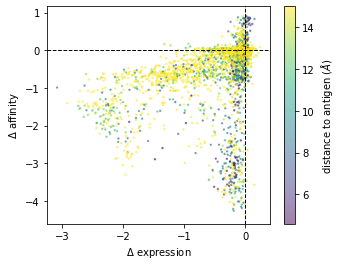

In [ ]:
plt.figure(figsize=(5, 4))
plt.scatter(dms_df.delta_expr, y=dms_df.delta_bind_CGG, c=dms_df["distance to antigen"],
            s=2, alpha=0.5,
#             cmap="viridis",
#             vmin=0,
            vmax=15
           )
plt.axvline(0, ls="--", c="k", lw=1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.xlabel(r"$\Delta$ expression")
plt.ylabel(r"$\Delta$ affinity")
plt.colorbar(label=r"distance to antigen ($\AA$)")
plt.savefig(f"{out_dir}/bind-expr-dist.pdf")
plt.show()

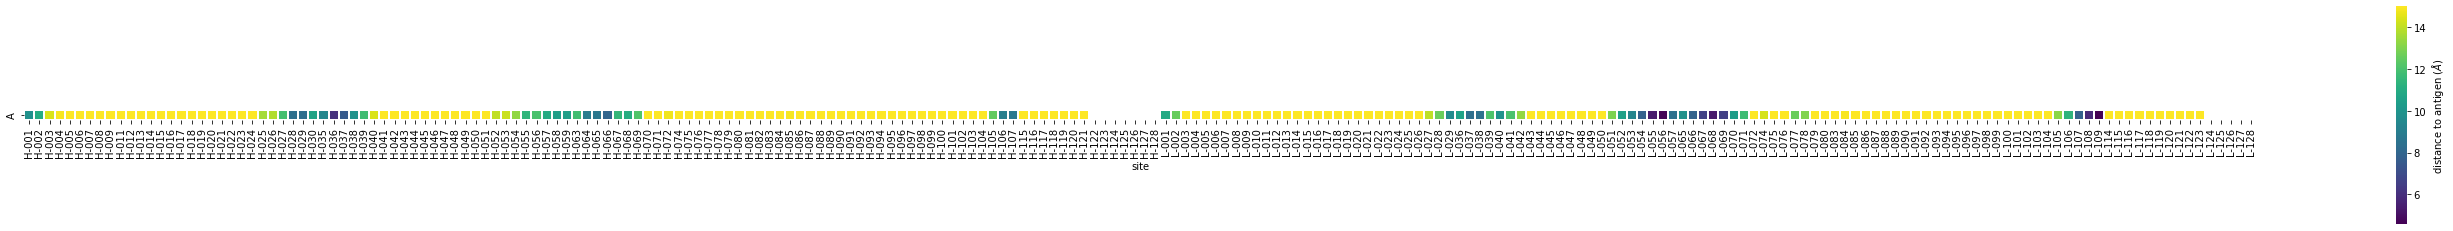

In [ ]:
# note: seaborn can combine this annotation into the below heatmap. Look up how when not on a plane
#       should make another stripe of distance from solvent and align with expression heatmap

plt.figure(figsize=(50, 4))
sns.heatmap(pd.DataFrame(dms_df.pivot(index="mutant", columns="site", values="distance to antigen").iloc[0, :]).T,
            vmax=15, cmap="viridis",
            cbar_kws=dict(label=r"distance to antigen ($\AA$)"), linewidths=.1, square=True)
plt.savefig(f"{out_dir}/bind-heatmap-distances-row.pdf")
plt.show()

## High-incidence mutations

In [ ]:
dms_df[["mutation events", "delta_bind_CGG"]].sort_values("mutation events", ascending=False)[:20]

,mutation events,delta_bind_CGG
mutation,,
S57(H)N,241,-0.01297
S64(H)N,159,0.02258
N108(L)K,141,0.86582
S109(L)N,135,-0.03494
Q105(L)H,123,0.18312
E101(L)D,112,-0.05815
Y42(L)F,98,-0.01086
S109(L)R,96,0.75471
A105(H)G,96,0.33100


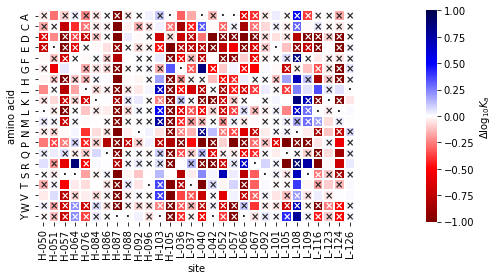

In [ ]:
# high_incidence = ["H-057", "H-064", "L-108", "L-109"]
high_incidence = dms_df.loc[dms_df["mutation events"] > dms_df["mutation events"].quantile(0.99)].site.unique()

plt.figure(figsize=(20, 4))
sns.heatmap(bind_df[high_incidence], center=0, vmin=vmin, vmax=vmax, annot=annot[high_incidence], fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.tight_layout()
# plt.savefig(f"{out_dir}/high-incidence.pdf")
plt.show()

## Pairwise epistasis

In [ ]:
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
mutations =  dms_df.index.unique()

n_mutations = 0
mutation_counts = pd.Series(0, index=mutations)

epi_df = pd.DataFrame(np.zeros((len(mutations), len(mutations))), index=mutations, columns=mutations)

for gc, tree in trees.items():
    print(gc, end="       \r")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        parent_mutations = set(mutation for mutation in node.up.mutations)
        new_mutations = set(mutation for mutation in node.mutations) - parent_mutations
        if any(mutation.endswith("*") for mutation in parent_mutations.union(new_mutations)):
            continue
        for new_mutation in new_mutations:
            n_mutations += 1
            mutation_counts[new_mutation] += 1
        for background_mutation in parent_mutations:
            for new_mutation in new_mutations:
                epi_df.loc[background_mutation, new_mutation] += 1

volcano_dat = []
                
for background_mutation in mutations:
    background_total = epi_df.loc[background_mutation, :].sum()
    if background_total >= 5:
        for new_mutation in mutations:
            if background_mutation[:-1] != new_mutation[:-1] and mutation_counts[new_mutation] >= 5:
                print(background_mutation, end="       \r")
                table = np.zeros((2, 2), dtype=int)
                table[0, 0] = n_mutations - epi_df.loc[background_mutation, new_mutation]
                table[0, 1] = mutation_counts[new_mutation] - epi_df.loc[background_mutation, new_mutation]
                table[1, 0] = background_total - epi_df.loc[background_mutation, new_mutation]
                table[1, 1] = epi_df.loc[background_mutation, new_mutation]
                
                odds_ratio, p_value = fisher_exact(table, alternative="two-sided")
                if p_value < 1e-6:
                    print(background_mutation, new_mutation, odds_ratio, p_value)
                volcano_dat.append([background_mutation, new_mutation, table, odds_ratio, p_value])

volcano_df = pd.DataFrame(volcano_dat, columns=["background mutation", "mutation event", "contingency table", "odds ratio", "p-value"])

_, volcano_df["FDR"] = fdrcorrection(volcano_df["p-value"], method="p")

FDR_tresh = 0.05
volcano_df[f"FDR < {FDR_tresh}"] = volcano_df.FDR < FDR_tresh

epi_muts = volcano_df[volcano_df[f"FDR < {FDR_tresh}"]].sort_values("p-value")
epi_muts

A105(H)G S57(H)N 2.5128307359017152 8.389665373679861e-16
A105(H)G S64(H)R 4.363210148924435 4.8442337625480556e-14
A105(H)G T37(L)S 4.295808 1.5626492813682916e-08
A105(H)G E101(L)D 2.3086922587384877 6.280172265644905e-07
A105(H)G Q105(L)H 2.9147842141703206 4.311956398812826e-12
A105(H)G N108(L)H 4.552963732225595 2.3688633477179952e-07
A105(H)G N108(L)K 2.9972908963895657 8.043983462198944e-14
A105(H)G S109(L)N 2.649027686287044 2.508555469988343e-11
A105(H)G S109(L)R 4.310667096358363 1.703054741694955e-15
A105(H)G K123(L)N 3.908945174735492 1.0465636277483447e-09
N108(L)K S109(L)T 3.070434345128291 1.0745928563002762e-07


,background mutation,mutation event,contingency table,odds ratio,p-value,FDR,FDR < 0.05
98108,A105(H)G,S57(H)N,"[[12071, 139], [6117, 177]]",2.512831,8.389665e-16,1.837857e-10,True
98474,A105(H)G,S109(L)R,"[[12160, 40], [6206, 88]]",4.310667,1.703055e-15,1.865373e-10,True
98130,A105(H)G,S64(H)R,"[[12170, 35], [6216, 78]]",4.363210,4.844234e-14,3.537292e-09,True
98465,A105(H)G,N108(L)K,"[[12132, 76], [6178, 116]]",2.997291,8.043983e-14,4.405328e-09,True
98454,A105(H)G,Q105(L)H,"[[12144, 70], [6190, 104]]",2.914784,4.311956e-12,1.889172e-07,True
98473,A105(H)G,S109(L)N,"[[12136, 83], [6182, 112]]",2.649028,2.508555e-11,9.158820e-07,True
98494,A105(H)G,K123(L)N,"[[12192, 28], [6238, 56]]",3.908945,1.046564e-09,3.275176e-05,True
98316,A105(H)G,T37(L)S,"[[12204, 20], [6250, 44]]",4.295808,1.562649e-08,4.278963e-04,True
200087,N108(L)K,S109(L)T,"[[12206, 67], [2492, 42]]",3.070434,1.074593e-07,2.615583e-03,True
98463,A105(H)G,N108(L)H,"[[12213, 15], [6259, 35]]",4.552964,2.368863e-07,5.189279e-03,True


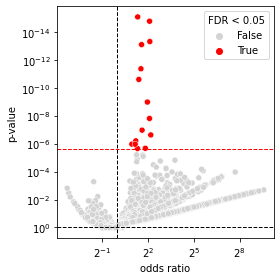

In [ ]:
plt.figure(figsize=(4, 4))
ax = sns.scatterplot(data=volcano_df, x="odds ratio", y="p-value", hue=f"FDR < {FDR_tresh}", palette=["lightgrey", "red"])
ax.invert_yaxis()
plt.axvline(1, ls="--", c="k", lw=1)
plt.axhline(1, ls="--", c="k", lw=1)
plt.axhline(volcano_df.loc[volcano_df[f"FDR < {FDR_tresh}"], "p-value"].max(), ls="--", c="red", lw=1)
plt.xscale("log", base=2)
plt.yscale("log")
plt.tight_layout()
plt.savefig(f"{out_dir}/epistasis.volcano.pdf")
plt.show()

In [ ]:
epi_muts.to_csv(f"{out_dir}/epistatic-pairs.csv", index=False)

Where are the above mutations in our scatters?

In [ ]:
background_indicator = dms_df.index.isin(epi_muts["background mutation"])
enabled_indicator = dms_df.index.isin(epi_muts["mutation event"])
indicator = ["other"] * len(dms_df)
for i in range(len(indicator)):
    if background_indicator[i]:
        indicator[i] = "epistatic background mutation"
    elif enabled_indicator[i]:
        indicator[i] = "epistatically enabled mutation"
indicator = pd.Series(indicator, index=dms_df.index, name="mutation type")

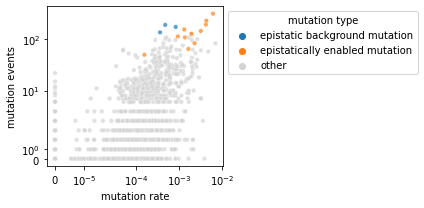

In [ ]:
plt.figure(figsize=(6, 3))

ax = sns.scatterplot(x=dms_df["mutation rate"], y=dms_df["mutation events"], hue=indicator, s=20, alpha=0.7,
                     hue_order=("epistatic background mutation", "epistatically enabled mutation", "other"),
                     palette=("C0", "C1", "lightgrey"),
                     clip_on=False, edgecolors="k", linewidths=0.1)
# plt.xlabel("mutation rate")
plt.ylabel("mutation events")
linthresh_x = 3 * dms_df.loc[dms_df["mutation rate"] > 0, "mutation rate"].min()
linthresh_y = 6
plt.xscale("symlog", linthresh=linthresh_x)
plt.yscale("symlog", linthresh=linthresh_y)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{out_dir}/eventsVsrate-epistatic.pdf")
plt.show()

LBI of nodes with the above mutations

,LBI,LBR,mutation pair on tree node
0,9.554107,0.266392,enabling mutation only
1,9.914952,0.314222,enabling mutation only
2,11.493064,0.523399,enabling and enabled mutation
3,13.294327,0.762156,enabling and enabled mutation
4,6.233345,0.464224,enabling and enabled mutation
...,...,...,...
391,5.172864,1.182518,enabling mutation only
392,5.240694,2.349252,enabling mutation only
393,2.489571,0.000000,enabling mutation only
394,4.421468,0.775996,enabling mutation only


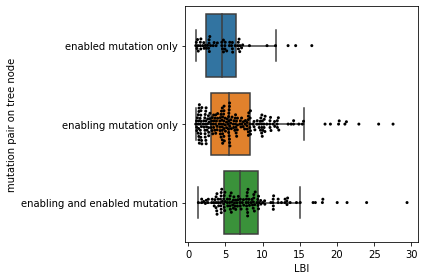

In [ ]:
lbi_dat = []
pairs = set((x, y) for x, y in volcano_df.loc[volcano_df[f"FDR < {FDR_tresh}"], ["background mutation", "mutation event"]].values)
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        mutations = set(node.mutations)
        # if node.get_distance(tree.tree) <= 4:
        if len(mutations) == 2:
            if any(set(pair) <= mutations for pair in pairs):            
                lbi_dat.append([node.LBI, node.LBR, "enabling and enabled mutation"])
            elif any(pair[0] in mutations for pair in pairs):
                lbi_dat.append([node.LBI, node.LBR, "enabling mutation only"])
            elif any(pair[1] in mutations for pair in pairs):
                lbi_dat.append([node.LBI, node.LBR, "enabled mutation only"])
            # else:
            #     lbi_dat.append([node.LBI, node.LBR, "none"])

lbi_df = pd.DataFrame(lbi_dat, columns=("LBI", "LBR", "mutation pair on tree node"))

display(lbi_df)

# plt.figure(figsize=(10, 3))
sns.boxplot(data=lbi_df, y="mutation pair on tree node", x="LBI", order=("enabled mutation only", "enabling mutation only", "enabling and enabled mutation"), fliersize=0)
sns.swarmplot(data=lbi_df, y="mutation pair on tree node", x="LBI", order=("enabled mutation only", "enabling mutation only", "enabling and enabled mutation"), color="k", size=3)
plt.tight_layout()
plt.savefig(f"{out_dir}/epistasis.LBI.pdf")
plt.show()


In [ ]:
from scipy.stats import kruskal, mannwhitneyu

kruskal(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
        lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI,
        lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

NameError: name 'lbi_df' is not defined

In [ ]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI)

MannwhitneyuResult(statistic=4808.0, pvalue=0.02290827591336011)

In [ ]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

MannwhitneyuResult(statistic=1904.0, pvalue=7.449910391994538e-07)

In [ ]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

MannwhitneyuResult(statistic=10255.5, pvalue=0.00022833279597547044)

### Redoing above using Yun's approach of coincidence of mutations on nodes

In [ ]:
n_mutations, mutation_counts.sum()

(24677, 24677)

In [ ]:
mutations =  dms_df.index.unique()

n_mutations = 0
mutation_counts = pd.Series(0, index=mutations)

epi_df = pd.DataFrame(np.zeros((len(mutations), len(mutations))), index=mutations, columns=mutations)

for gc, tree in trees.items():
    print(gc, end="       \r")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        if any(mutation.endswith("*") for mutation in node.mutations):
            continue
        for i, mutation1 in enumerate(node.mutations):
            n_mutations += 1
            mutation_counts[mutation1] += 1
            for mutation2 in node.mutations[i + 1:]:
                epi_df.loc[mutation1, mutation2] += 1

volcano_dat = []
                
for i, mutation1 in enumerate(mutations):
    mutation1_total = mutation_counts[mutation1]
    if mutation1_total >= 50:
        for mutation2 in mutations[i + 1:]:
            if mutation1[:-1] != mutation2[:-1] and mutation_counts[mutation2] >= 5:
                print(mutation1, end="       \r")
                table = np.zeros((2, 2), dtype=int)
                table[0, 0] = n_mutations - epi_df.loc[mutation1, mutation2]
                table[0, 1] = mutation_counts[mutation2] - epi_df.loc[mutation1, mutation2]
                table[1, 0] = mutation1_total - epi_df.loc[mutation1, mutation2]
                table[1, 1] = epi_df.loc[mutation1, mutation2]
                
                odds_ratio, p_value = fisher_exact(table, alternative="two-sided")
                row = [mutation1, mutation2, table, odds_ratio, p_value]
                if p_value < 1e-6:
                    print(row)
                volcano_dat.append(row)

volcano_df = pd.DataFrame(volcano_dat, columns=["mutation 1", "mutation 2", "contingency table", "odds ratio", "p-value"])

_, volcano_df["FDR"] = fdrcorrection(volcano_df["p-value"], method="p")

FDR_tresh = 0.05
volcano_df[f"FDR < {FDR_tresh}"] = volcano_df.FDR < FDR_tresh

volcano_df[volcano_df[f"FDR < {FDR_tresh}"]].sort_values("p-value")

['E1(H)D', 'D28(H)A', array([[24660,   145],
       [   44,    17]]), 65.70846394984326, 1.2172383917167712e-23]
['E1(H)D', 'A105(H)G', array([[24619,  2740],
       [    3,    58]]), 173.71070559610706, 4.991940869630904e-54]
['E1(H)D', 'G36(L)N', array([[24639,    11],
       [   23,    38]]), 3700.719367588933, 6.84898557859867e-96]
['E1(H)D', 'N108(L)H', array([[24658,   277],
       [   42,    19]]), 40.270070483066874, 2.637413696943779e-22]
['E1(H)D', 'N108(L)S', array([[24659,   151],
       [   43,    18]]), 68.36008008624673, 3.8443471987816477e-25]
['E1(H)D', 'N108(L)Y', array([[24664,   205],
       [   48,    13]]), 32.58455284552846, 5.5323936659273e-15]
['E1(H)D', 'S109(L)T', array([[24659,   145],
       [   43,    18]]), 71.1887730553328, 1.9625388443028533e-25]
['D28(H)A', 'T35(H)A', array([[24654,     5],
       [  139,    23]]), 815.8877697841726, 1.0260496971905745e-46]
['D28(H)A', 'N40(H)C', array([[24650,     1],
       [  135,    27]]), 4930.0, 2.848687424478204

,mutation 1,mutation 2,contingency table,odds ratio,p-value,FDR,FDR < 0.05
15052,A105(H)G,N108(L)K,"[[23935, 357], [2056, 742]]",24.196136,0.000000e+00,0.000000e+00,True
4203,S57(H)N,A105(H)G,"[[24243, 2364], [289, 434]]",15.400357,5.182474e-246,5.409466e-242,True
20382,Q105(L)H,L116(L)I,"[[24456, 227], [449, 221]]",53.028031,3.086490e-235,2.147785e-231,True
15061,A105(H)G,S109(L)R,"[[24369, 137], [2490, 308]]",22.002322,3.788345e-200,1.977137e-196,True
6140,S64(H)R,A105(H)G,"[[24378, 2499], [132, 299]]",22.096784,1.177397e-194,4.915867e-191,True
...,...,...,...,...,...,...,...
789,D28(H)A,Q48(L)H,"[[24675, 13], [160, 2]]",23.725962,4.194509e-03,4.941567e-02,True
6060,S64(H)R,S77(H)F,"[[24675, 4], [429, 2]]",28.758741,4.212131e-03,4.959529e-02,True
14773,Y103(H)F,E101(L)D,"[[24672, 164], [151, 5]]",4.981425,4.235827e-03,4.984618e-02,True
857,D28(H)A,T88(L)I,"[[24674, 47], [159, 3]]",9.905259,4.242858e-03,4.990079e-02,True
